In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error

In [3]:
# Load datasets
example_flight = pd.read_csv('example_flight.csv')
flights = pd.read_csv('flights.csv')

In [4]:
#Preprocessing DateTime columns to datetime objects for visualization
example_flight['DateTime'] = pd.to_datetime(example_flight['DateTime'], errors='coerce')
flights['DateTime'] = pd.to_datetime(flights['DateTime'], errors='coerce')


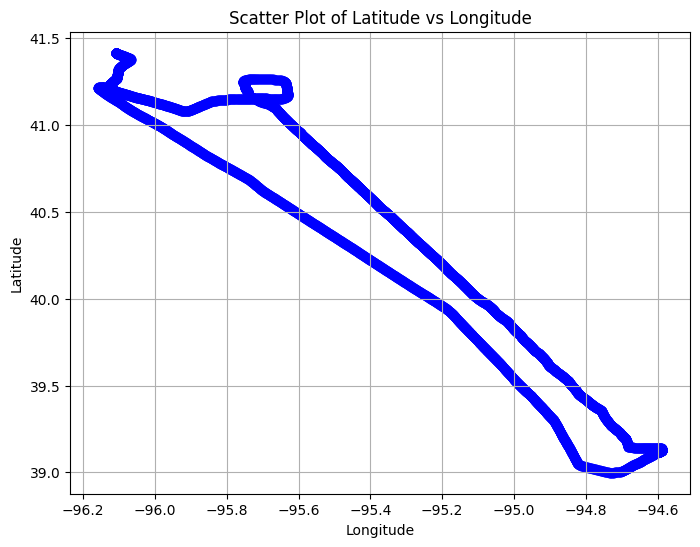

In [5]:
# Scatter plot: Latitude vs Longitude
plt.figure(figsize=(8, 6))
plt.scatter(example_flight['Longitude'], example_flight['Latitude'], alpha=0.5, c='blue')
plt.title('Scatter Plot of Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [36]:
#Visualing the above plot of Latitude vs Longitude but in a real map
import folium
from folium import PolyLine

# Ensure Latitude and Longitude columns are not null
example_flight = example_flight.dropna(subset=['Latitude', 'Longitude'])

# Create a base map centered at the mean latitude and longitude
map_center = [example_flight['Latitude'].mean(), example_flight['Longitude'].mean()]
flight_map = folium.Map(location=map_center, zoom_start=10)

# Extract the latitude and longitude as a list of tuples for the polyline
lat_lon_points = example_flight[['Latitude', 'Longitude']].values.tolist()

# Add a polyline to the map to connect the points
folium.PolyLine(
    locations=lat_lon_points,
    color="blue",  # Line color
    weight=3,      # Line thickness
    opacity=0.8    # Line transparency
).add_to(flight_map)

# Save the map to an HTML file
map_path = 'flight_path_map.html'
flight_map.save(map_path)

print(f"Flight path map has been saved to {map_path}. Open it in a browser to view.")


Flight path map has been saved to flight_path_map.html. Open it in a browser to view.


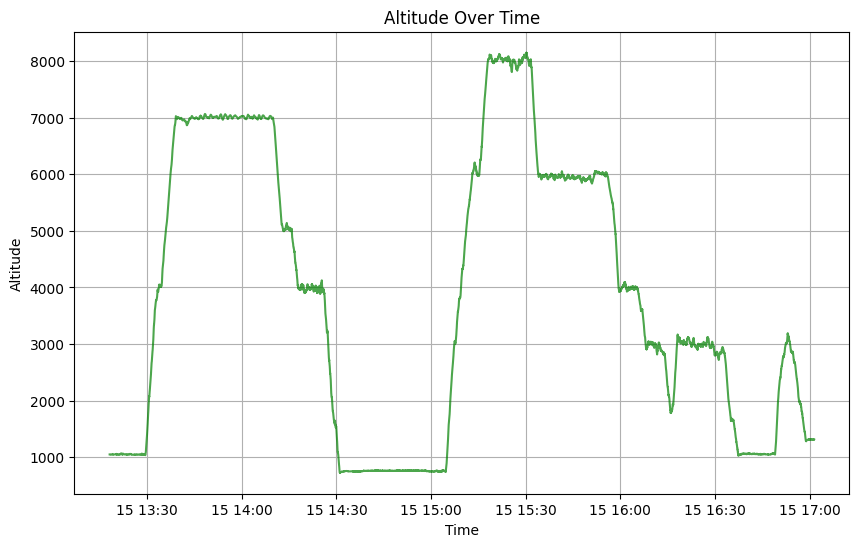

In [6]:
# Line plot: Altitude over time
plt.figure(figsize=(10, 6))
plt.plot(example_flight['DateTime'], example_flight['Altitude'], color='green', alpha=0.7)
plt.title('Altitude Over Time')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.grid(True)
plt.show()

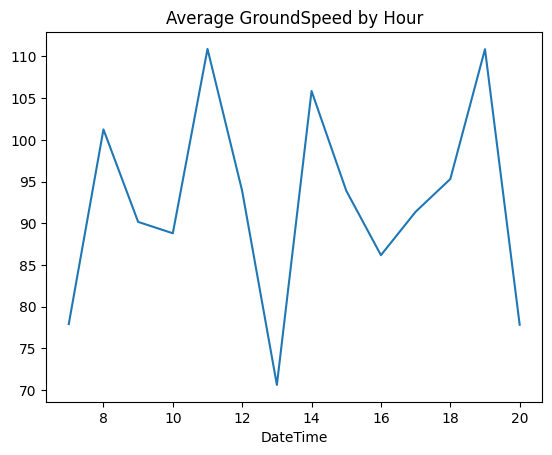

In [28]:
#Grouping data
hourly_avg = flights.groupby(flights['DateTime'].dt.hour)['GroundSpeed'].mean()
hourly_avg.plot(kind='line', title='Average GroundSpeed by Hour')
plt.show()


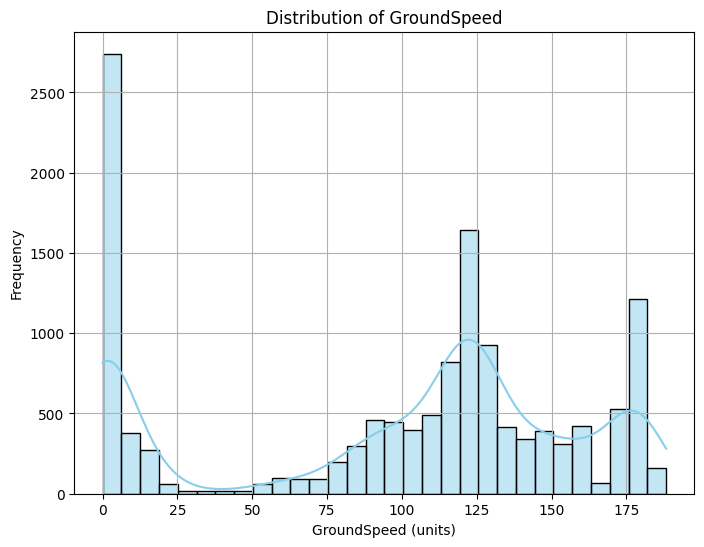

In [7]:
# Histogram: GroundSpeed
plt.figure(figsize=(8, 6))
sns.histplot(example_flight['GroundSpeed'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of GroundSpeed')
plt.xlabel('GroundSpeed (units)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

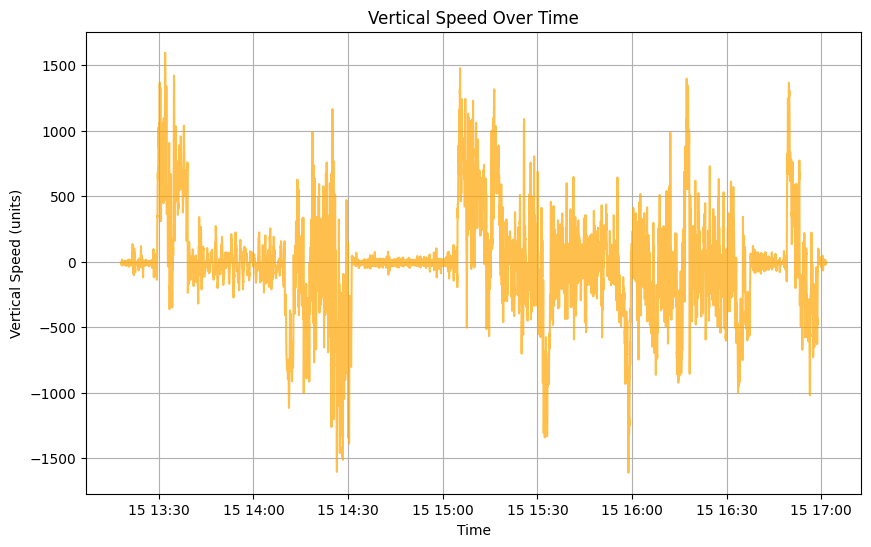

In [10]:
# Line plot: VerticalSpeed over time
plt.figure(figsize=(10, 6))
plt.plot(example_flight['DateTime'], example_flight['VerticalSpeed'], color='', alpha=0.7)
plt.title('Vertical Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Vertical Speed (units)')
plt.grid(True)
plt.show()


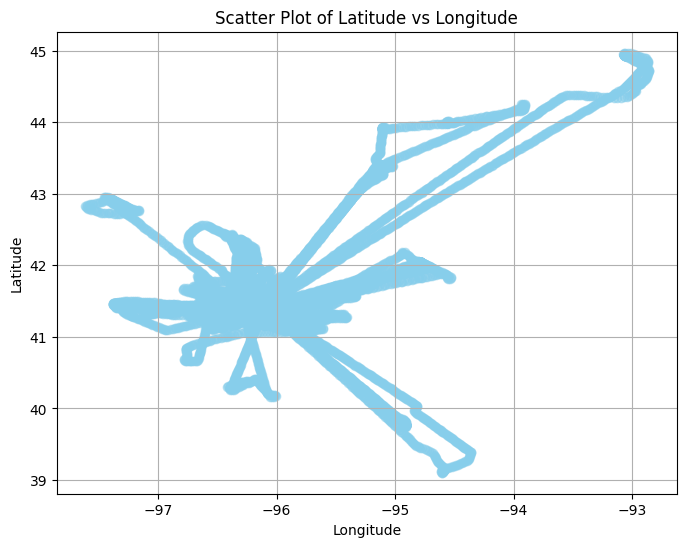

In [15]:
# Scatter plot: Latitude vs Longitude
plt.figure(figsize=(8, 6))
plt.scatter(flights['Longitude'], flights['Latitude'], alpha=0.5, c='skyblue')
plt.title('Scatter Plot of Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

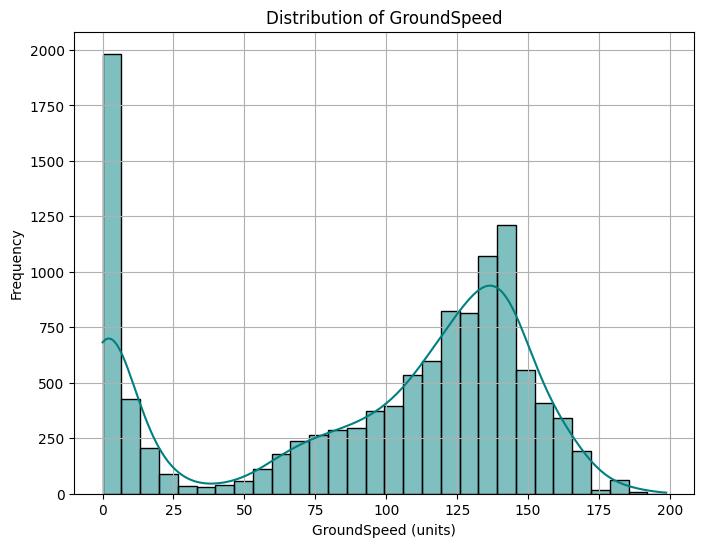

In [17]:
# Histogram: GroundSpeed
plt.figure(figsize=(8, 6))
sns.histplot(flights['GroundSpeed'], bins=30, kde=True, color='teal')
plt.title('Distribution of GroundSpeed')
plt.xlabel('GroundSpeed (units)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

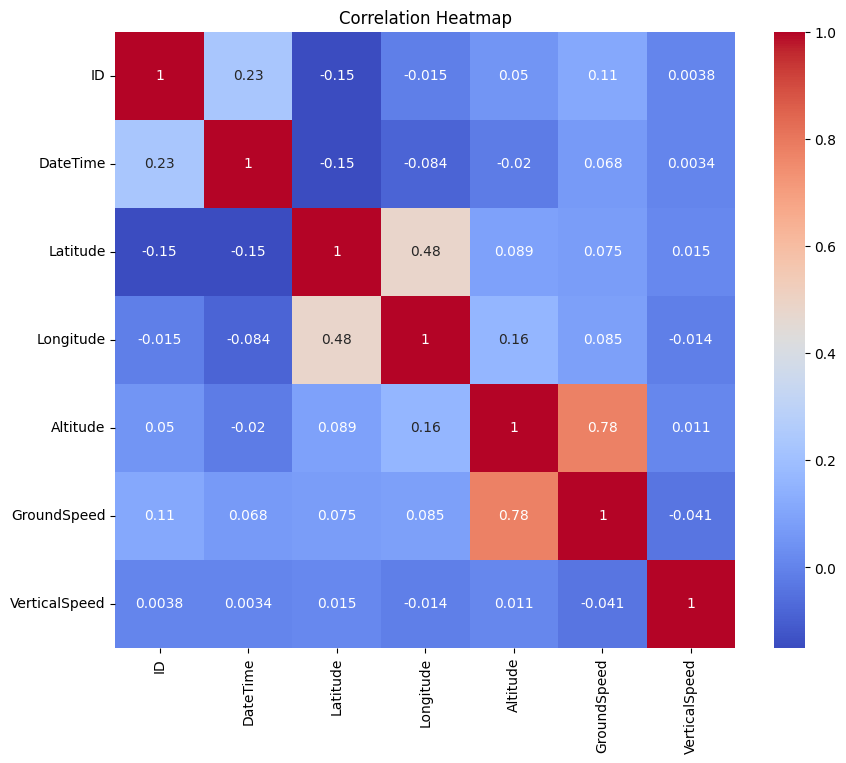

In [22]:
#Visualising correlation in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(flights.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



Using the Linear Interpolation method to predict missing values

In [53]:
# Create a copy of the original dataset for interpolation
flights_interpolated = flights.copy()


In [54]:
# Linear interpolation will estimate missing values between known data points
flights_interpolated = flights_interpolated.interpolate(method='linear', limit_direction='both')


In [55]:
# Renaming columns for compatibility or standardization
columns_to_rename = {
    "Latitude": "Lat",
    "Longitude": "Lon",
    "Altitude": "Alt",
    "GroundSpeed": "GSp",
    "VerticalSpeed": "VSp",
}
flights_interpolated.rename(columns=columns_to_rename, inplace=True)

In [60]:
# Adding a row identifier for reshaping or tracking
flights_interpolated['row'] = flights_interpolated.index + 1


In [61]:
# Reshape the interpolated data into a long format for submission
# 'melt' transforms the data into a long format with row IDs
columns_to_melt = ["Lat", "Lon", "Alt", "GSp", "VSp"]
flights_long = flights_interpolated.melt(
    id_vars=['row'],  # Identifier columns
    value_vars=columns_to_melt,  # Columns to reshape
    var_name='name',  # New column for variable names
    value_name='value'  # New column for values
)

In [62]:
# Update 'row' column to include variable names
flights_long['row'] = flights_long['row'].astype(str) + '-' + flights_long['name']


In [63]:
#Validate that all expected rows are included
expected_keys = [f"{i}-{name}" for i in range(1, len(flights_interpolated) + 1) for name in columns_to_melt]
missing_keys = set(expected_keys) - set(flights_long['row'].values)


In [64]:
#Save the reshaped data for submission
flights_submission = flights_long[['row', 'value']]
csv_path = 'flights_interpolated_submission.csv'
flights_submission.to_csv(csv_path, index=False)

In [65]:
data = pd.read_csv('flights_interpolated_submission.csv')
data.head()

,row,value
0,1-Lat,41.257782
1,2-Lat,41.257782
2,3-Lat,41.257782
3,4-Lat,41.257782
4,5-Lat,41.257782


Validation Function for Weighted Mean Absolute Error (MAE) using example flight dataset

In [9]:
example_flight_df = example_flight

# Simulate missing values in the example_flight dataset
np.random.seed(42)
example_flight_missing = example_flight_df.copy()

# Randomly mask 20% of the data in each column (excluding 'DateTime')
columns_to_mask = ['Latitude', 'Longitude', 'Altitude', 'GroundSpeed', 'VerticalSpeed']
for column in columns_to_mask:
    mask = np.random.rand(len(example_flight_missing)) < 0.2  # 20% missing data
    example_flight_missing.loc[mask, column] = np.nan

# Linear interpolation to fill missing values
example_flight_interpolated = example_flight_missing.interpolate(method='linear', limit_direction='both')

# Compute Mean Absolute Error (MAE) for each column
mae_scores = {}
for column in columns_to_mask:
    # Select rows with originally known values in the simulated dataset
    actual = example_flight_df[column]
    predicted = example_flight_interpolated[column]

    # Drop NaNs from both actual and predicted arrays and align indices
    valid_data = pd.concat([actual, predicted], axis=1).dropna()
    actual = valid_data.iloc[:, 0].values
    predicted = valid_data.iloc[:, 1].values

    # Calculate MAE
    mae_scores[column] = mean_absolute_error(actual, predicted)

# Define weights for WMAE calculation
weights = {
    'Latitude': 1043.291805,
    'Longitude': 1443.617029,
    'Altitude': 0.590648,
    'GroundSpeed': 17.754914,
    'VerticalSpeed': 2.857594,
}

# Compute Weighted Mean Absolute Error (WMAE)
wmae = sum(weights[col] * mae_scores[col] for col in columns_to_mask) / sum(weights.values())

# Print MAE for each column and WMAE
print("Mean Absolute Error (MAE) per column:")
for column, mae in mae_scores.items():
    print(f"{column}: {mae:.6f}")
print(f"Weighted Mean Absolute Error (WMAE): {wmae:.6f}")


Mean Absolute Error (MAE) per column:
Latitude: 0.000001
Longitude: 0.000001
Altitude: 0.434153
GroundSpeed: 0.011995
VerticalSpeed: 4.231670
Weighted Mean Absolute Error (WMAE): 0.005009


Second best model used Spline Interpolation (Cubic)


In [27]:
import pandas as pd
import numpy as np

#Load the dataset
flights_df = pd.read_csv('flights.csv')

In [28]:
# Display the first few rows to understand the structure of the dataset
print("Original Dataset:")
print(flights_df.head())

Original Dataset:
   ID             DateTime   Latitude  Longitude  Altitude  GroundSpeed  \
0   1  2022-09-16 19:40:41  41.257782 -95.761818    1239.0          0.0   
1   1  2022-09-16 19:40:42        NaN        NaN       NaN          NaN   
2   1  2022-09-16 19:40:43        NaN        NaN       NaN          NaN   
3   1  2022-09-16 19:40:44        NaN        NaN       NaN          NaN   
4   1  2022-09-16 19:40:45        NaN        NaN       NaN          NaN   

   VerticalSpeed  
0          -4.34  
1            NaN  
2            NaN  
3            NaN  
4            NaN  


In [29]:
#Identify columns with missing values
columns_with_missing = ['Latitude', 'Longitude', 'Altitude', 'GroundSpeed', 'VerticalSpeed']


In [30]:
# Use cubic spline interpolation to fill missing values
# Explanation:
# - The `interpolate` method with `spline` uses cubic splines to estimate missing values.
# - The `order=3` specifies cubic interpolation.
# - `limit_direction='both'` ensures that interpolation works for both ends of the data.
flights_interpolated = flights.copy()
columns_to_interpolate = ['Latitude', 'Longitude', 'Altitude', 'GroundSpeed', 'VerticalSpeed']
for column in columns_to_interpolate:
    flights_interpolated[column] = flights_interpolated[column].interpolate(
        method='spline', order=3, limit_direction='both'
    )

In [26]:
# Comparing the dataset before and after interpolation
print("\nDataset After Cubic Spline Interpolation:")
print(flights_interpolated.head())



Dataset After Cubic Spline Interpolation:
   ID             DateTime   Latitude  Longitude     Altitude  GroundSpeed  \
0   1  2022-09-16 19:40:41  41.257782 -95.761818  1239.000000     0.000000   
1   1  2022-09-16 19:40:42  41.989417 -95.921603  1240.282760     0.152136   
2   1  2022-09-16 19:40:43  41.989416 -95.921602  1240.692246     0.089802   
3   1  2022-09-16 19:40:44  41.989415 -95.921602  1241.089027     0.031456   
4   1  2022-09-16 19:40:45  41.989415 -95.921601  1241.473275    -0.022988   

   VerticalSpeed  
0      -4.340000  
1      -3.192130  
2      -1.999052  
3      -0.931797  
4       0.014195  


In [32]:
# Renaming columns for compatibility or standardization
columns_to_rename = {
    "Latitude": "Lat",
    "Longitude": "Lon",
    "Altitude": "Alt",
    "GroundSpeed": "GSp",
    "VerticalSpeed": "VSp",
}
flights_interpolated.rename(columns=columns_to_rename, inplace=True)

# Adding a row identifier for reshaping or tracking
flights_interpolated['row'] = flights_interpolated.index + 1

# Reshape the interpolated data into a long format for submission
# 'melt' transforms the data into a long format with row IDs
columns_to_melt = ["Lat", "Lon", "Alt", "GSp", "VSp"]
flights_long = flights_interpolated.melt(
    id_vars=['row'],  # Identifier columns
    value_vars=columns_to_melt,  # Columns to reshape
    var_name='name',  # New column for variable names
    value_name='value'  # New column for values
)


In [33]:
# Create the 'row' column in the required format
flights_long['row'] = flights_long['row'].astype(str) + '-' + flights_long['name']

# Ensure all expected rows are included
expected_keys = [f"{i}-{name}" for i in range(1, len(flights_interpolated) + 1) for name in columns_to_melt]
missing_keys = set(expected_keys) - set(flights_long['row'].values)

# Save the reshaped data for submission
flights_submission = flights_long[['row', 'value']]
csv_path = 'flights_cubic_spline_submission.csv'
flights_submission.to_csv(csv_path, index=False)

print(f"Cubic spline interpolation complete. Submission file saved to: {csv_path}")

Cubic spline interpolation complete. Submission file saved to: flights_cubic_spline_submission.csv


In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Load the datasets
example_flight_df = example_flight

# Simulate missing values in the example_flight dataset
np.random.seed(42)
example_flight_missing = example_flight_df.copy()

# Randomly mask 20% of the data in each column (excluding 'DateTime')
columns_with_missing = ['Latitude', 'Longitude', 'Altitude', 'GroundSpeed', 'VerticalSpeed']
for column in columns_with_missing:
    mask = np.random.rand(len(example_flight_missing)) < 0.2  # 20% missing data
    example_flight_missing.loc[mask, column] = np.nan

# Cubic spline interpolation to fill missing values
example_flight_interpolated = example_flight_missing.copy()
for column in columns_with_missing:
    example_flight_interpolated[column] = example_flight_interpolated[column].interpolate(
        method='spline', order=3, limit_direction='both'
    )

# Compute Mean Absolute Error (MAE) for each column using the original and interpolated dataset
mae_scores = {}
for column in columns_with_missing:
    # Extract actual and predicted values for non-missing data in the original dataset
    actual = example_flight_df[column]
    predicted = example_flight_interpolated[column]

    # Drop NaNs from both actual and predicted arrays and align indices
    valid_data = pd.concat([actual, predicted], axis=1).dropna()
    actual = valid_data.iloc[:, 0].values
    predicted = valid_data.iloc[:, 1].values

    # Calculate MAE
    mae_scores[column] = mean_absolute_error(actual, predicted)

# Define weights for WMAE calculation
weights = {
    'Latitude': 1043.291805,
    'Longitude': 1443.617029,
    'Altitude': 0.590648,
    'GroundSpeed': 17.754914,
    'VerticalSpeed': 2.857594,
}

# Compute Weighted Mean Absolute Error (WMAE)
wmae = sum(weights[col] * mae_scores[col] for col in columns_with_missing) / sum(weights.values())

# Print MAE for each column and WMAE
print("Mean Absolute Error (MAE) per column using Cubic Spline Interpolation:")
for column, mae in mae_scores.items():
    print(f"{column}: {mae:.6f}")
print(f"Weighted Mean Absolute Error (WMAE): {wmae:.6f}")


Mean Absolute Error (MAE) per column using Cubic Spline Interpolation:
Latitude: 0.036971
Longitude: 0.019185
Altitude: 0.499803
GroundSpeed: 0.161770
VerticalSpeed: 2.856139
Weighted Mean Absolute Error (WMAE): 0.030939
